<a href="https://colab.research.google.com/github/Vidi005/COVID-19-Prediction-Indonesia/blob/master/COVID_19_Prediciton_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/COVID-19-Prediction-Indonesia/trunk/datasets > /dev/null

In [0]:
data=pd.read_csv("datasets/Daily-Update IDN-COVID19 - Sheet5.csv")
#data=data.drop('Date', axis=1)
#data=data.drop('No',axis=1)
data=data.rename(columns={"Date": "Tanggal",                                                     
                          "New_case_per_day": "Terkonfirmasi",
                          "Death_cases_perDay": "Meninggal",
                          "Recovered-cases_perDay": "Sembuh",
                          "Recovered_cases": "Jumlah Sembuh",
                          "Total_death": "Jumlah Meninggal",
                          "Cumulative_cases": "Jumlah Kasus"})

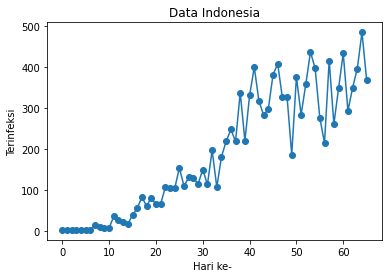

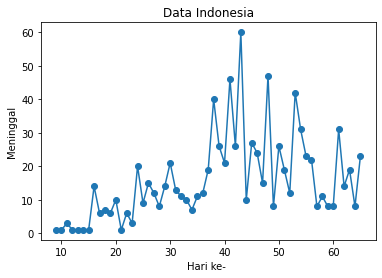

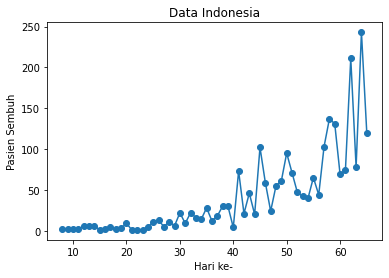

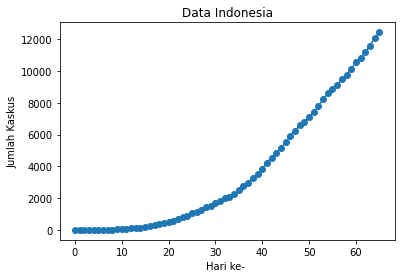

In [6]:
plt.plot(data.aggregate("Terkonfirmasi",axis=0), marker='o')
plt.xlabel("Hari ke- ")
plt.ylabel("Terinfeksi")
plt.title("Data Indonesia")
#plt.legend()
plt.show()

plt.plot(data.aggregate("Meninggal",axis=0), marker='o')
plt.xlabel("Hari ke- ")
plt.ylabel("Meninggal")
plt.title("Data Indonesia")
#plt.legend()
plt.show()

plt.plot(data.aggregate("Sembuh",axis=0), marker='o')
plt.xlabel("Hari ke- ")
plt.ylabel("Pasien Sembuh")
plt.title("Data Indonesia")
#plt.legend()
plt.show()

plt.plot(data.aggregate("Jumlah Kasus",axis=0), marker='o')
plt.xlabel("Hari ke- ")
plt.ylabel("Jumlah Kaskus")
plt.title("Data Indonesia")
#plt.legend()
plt.show()

In [0]:
def plot_predict(stat, future_days):
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        return (c / (1 + np.exp(-b*(x-a))))

    inception = 0
    # hardcoding day 0 for several countries based on observations
    #if country=="South Korea": inception = 8
    #if country=="US": inception = 28
    #if country=="Italy": inception = 20
    #covid_data = data[data["Negara"]==country].copy()
    graph = data.groupby("Tanggal")[['Jumlah Kasus', 'Jumlah Meninggal', 'Jumlah Sembuh']].sum().reset_index()[inception:]
    y = graph[stat]
    x = np.arange(len(y))

    # fitting the data on the logistic function
    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox', bounds=([12., 0.001, y.mean()],[90., 2.5, 10*y.max()]))
    print(popt_sig)
    peakday = datetime.strftime(datetime.strptime(graph["Tanggal"][inception], "%Y-%m-%d")+timedelta(days=int(popt_sig[0])), "%m/%d/%Y")
    plt.figure(figsize=(16,8))

    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)

    print("Predictions:")
    for i in range(1,60):
        pday = datetime.strftime(datetime.strptime(graph["Tanggal"][inception], "%Y-%m-%d")+timedelta(days=len(y)+i-1), "%m/%d/%Y")
        print("%s: %d" % (pday, y_m[len(y)+i-1]))
    #print(country_graph)

    # creating the matplotlib visualization
    plt.plot(x_m, y_m, c='k', marker="x", label="sigmoid | error: "+str(avg_err(pcov_sig))) 
    plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)
    
    plt.plot(x, y, c='r', marker="o", label = stat)
    plt.xlabel("Hari ke- ")
    plt.ylabel("Jumlah Terinfeksi")
    plt.legend(prop={'size': 15})
    plt.title("Data Indonesia", size=15)
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[-1], str(graph["Tanggal"][len(y)+inception-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    plt.text(int(popt_sig[0]), 1, "peak: day " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 10)
    plt.plot(pday)
    plt.show()

[5.04959854e+01 1.01702799e-01 1.47146916e+04]
Predictions:
05/07/2020: 12194
05/08/2020: 12400
05/09/2020: 12591
05/10/2020: 12769
05/11/2020: 12935
05/12/2020: 13088
05/13/2020: 13229
05/14/2020: 13360
05/15/2020: 13480
05/16/2020: 13590
05/17/2020: 13691
05/18/2020: 13784
05/19/2020: 13868
05/20/2020: 13946
05/21/2020: 14017
05/22/2020: 14081
05/23/2020: 14140
05/24/2020: 14194
05/25/2020: 14242
05/26/2020: 14287
05/27/2020: 14327
05/28/2020: 14363
05/29/2020: 14397
05/30/2020: 14427
05/31/2020: 14454
06/01/2020: 14479
06/02/2020: 14501
06/03/2020: 14522
06/04/2020: 14540
06/05/2020: 14557
06/06/2020: 14572
06/07/2020: 14585
06/08/2020: 14598
06/09/2020: 14609
06/10/2020: 14619
06/11/2020: 14628
06/12/2020: 14636
06/13/2020: 14644
06/14/2020: 14651
06/15/2020: 14657
06/16/2020: 14662
06/17/2020: 14667
06/18/2020: 14672
06/19/2020: 14676
06/20/2020: 14680
06/21/2020: 14683
06/22/2020: 14686
06/23/2020: 14689
06/24/2020: 14691
06/25/2020: 14693
06/26/2020: 14695
06/27/2020: 14697
06/2

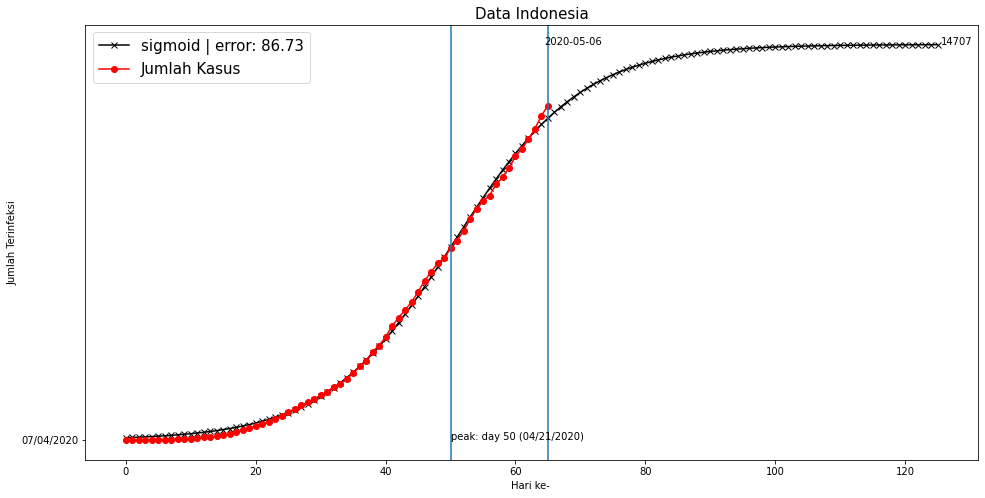

In [14]:
# See the results for different countries
#plot_predict("Mainland China", "confirm", 10)
#plot_predict("South Korea", "confirm", 10)
plot_predict("Jumlah Kasus", 60)